In [1]:
from __future__ import absolute_import, division, print_function

import dolfin as dl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import hippylib as hp

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=1)

In [2]:
ndim = 2
nx = 32
ny = 32
mesh = dl.UnitSquareMesh(nx, ny)
Vh2 = dl.FunctionSpace(mesh, 'Lagrange', 2)
Vh1 = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vh = [Vh2, Vh1, Vh2]
print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(
    Vh[hp.STATE].dim(), Vh[hp.PARAMETER].dim(), Vh[hp.ADJOINT].dim()) )

Number of dofs: STATE=4225, PARAMETER=1089, ADJOINT=4225


In [3]:
f = dl.Constant(0.0)
g = dl.Constant(1.0)
omega = dl.Constant(0.5)


def pde_varf(u,m,p):
    return -dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx + omega*omega*dl.exp(2*m)*dl.inner(u, p)*dl.dx - f*p*dl.dx  + m*p*dl.ds
    
pde = hp.PDEVariationalProblem(Vh, pde_varf, [], [], is_fwd_linear=True)


Prior regularization: (delta_x - gamma*Laplacian)^order: delta=8, gamma=1, order=-2


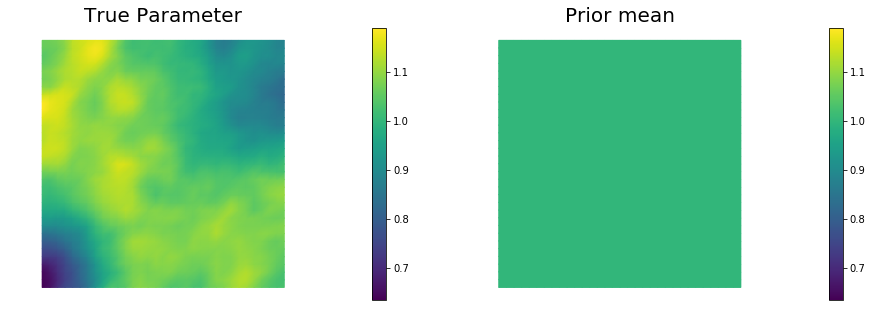

In [4]:
gamma = 1
delta = 8
prior = hp.BiLaplacianPrior(Vh[hp.PARAMETER], gamma, delta)

prior.mean = dl.interpolate(dl.Constant(1), Vh[hp.PARAMETER]).vector()

def true_model(prior):
    noise = dl.Vector()
    prior.init_vector(noise, "noise")
    hp.parRandom.normal(1., noise)
    mtrue = dl.Vector()
    prior.init_vector(mtrue, 0)
    prior.sample(noise,mtrue)
    return mtrue

print("Prior regularization: (delta_x - gamma*Laplacian)^order: delta={0}, gamma={1}, order={2}".format(delta, gamma, -2))    


mtrue = true_model(prior)
                   
objs = [dl.Function(Vh[hp.PARAMETER],mtrue), dl.Function(Vh[hp.PARAMETER],prior.mean)]
mytitles = ["True Parameter", "Prior mean"]
hp.nb.multi1_plot(objs, mytitles)
plt.show()



Number of observation points: 300


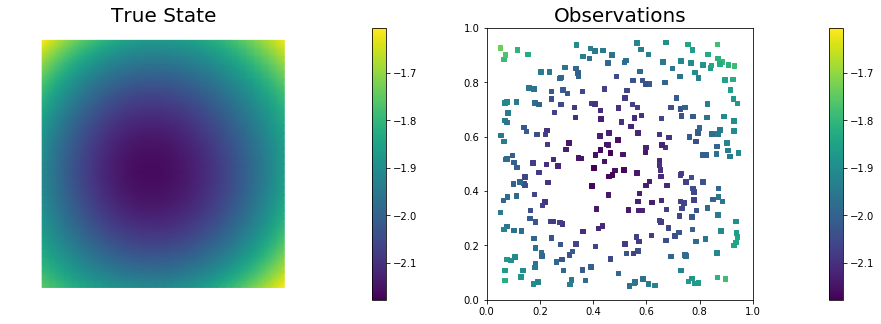

In [5]:
ntargets = 300
rel_noise = 0.005

targets = np.random.uniform(0.05,0.95, [ntargets, ndim] )
print( "Number of observation points: {0}".format(ntargets) )
misfit = hp.PointwiseStateObservation(Vh[hp.STATE], targets)


utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[hp.STATE], x, 1e-9)
misfit.B.mult(x[hp.STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
hp.parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), misfit.d.max() )
vmin = min( utrue.min(), misfit.d.min() )

plt.figure(figsize=(15,5))
hp.nb.plot(dl.Function(Vh[hp.STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
hp.nb.plot_pts(targets, misfit.d, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)
plt.show()

(yy, H xx) - (xx, H yy) =  1.915614119140254e-13


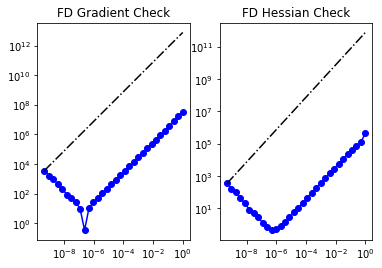

In [8]:
model = hp.Model(pde, prior, misfit)

m0 = dl.interpolate(dl.Expression("sin(x[0])", degree=5), Vh[hp.PARAMETER])
_ = hp.modelVerify(model, m0.vector(), 1e-12)

In [9]:
m = prior.mean.copy()
solver = hp.ReducedSpaceNewtonCG(model)
solver.parameters["rel_tolerance"] = 1e-6
solver.parameters["abs_tolerance"] = 1e-12
solver.parameters["max_iter"]      = 50
solver.parameters["inner_rel_tolerance"] = 1e-15
solver.parameters["GN_iter"] = 5
solver.parameters["globalization"] = "LS"
solver.parameters["LS"]["c_armijo"] = 1e-4

In [10]:
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    1.015457e+03    1.015216e+03    2.406260e-01   -9.173708e+04   5.708506e+06   1.000000e+00   5.000000e-01
  2   2    5.243206e+02    5.234019e+02    9.186639e-01   -1.546201e+03   2.122104e+05   1.000000e+00   1.928067e-01
  3   1    2.180968e+02    2.172231e+02    8.736833e-01   -6.124938e+02   3.795535e+05   1.000000e+00   2.578548e-01
  4   8    1.976847e+02    1.933969e+02    4.287853e+00   -1.345360e+02   2.194244e+04   5.000000e-01   6.199850e-02
  5   1    1.595732e+02    1.553016e+02    4.271593e+00   -7.622993e+01   1.380263e+05   1.000000e+00   1.554961e-01
  6   7    1.549598e+02    1.493291e+02    5.630714e+00   -4.864680e+01   1.138526e+04   2.500000e-01   4.465913e-02
  7   1    1.492064e+02    1.435823e+02    5.624091e+00   -1.150894e+01   5.363339e+04   1.000000e+00   9.692959e-02
  8  11    1.483989e+02    1.424939e+02    5.904997e+00   -3.

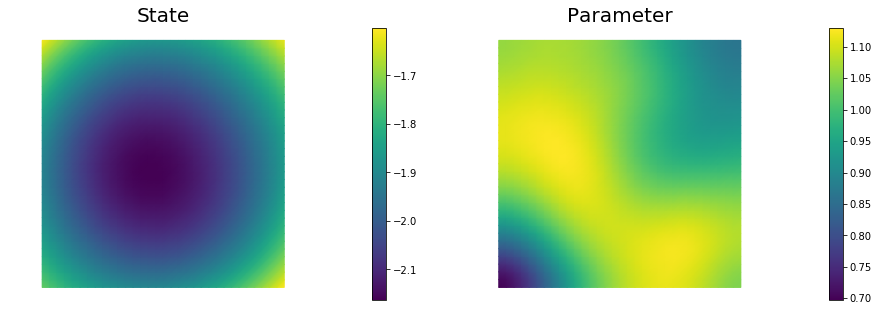

In [12]:
plt.figure(figsize=(15,5))
hp.nb.plot(dl.Function(Vh[hp.STATE], x[hp.STATE]), subplot_loc=121,mytitle="State")
hp.nb.plot(dl.Function(Vh[hp.PARAMETER], x[hp.PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()

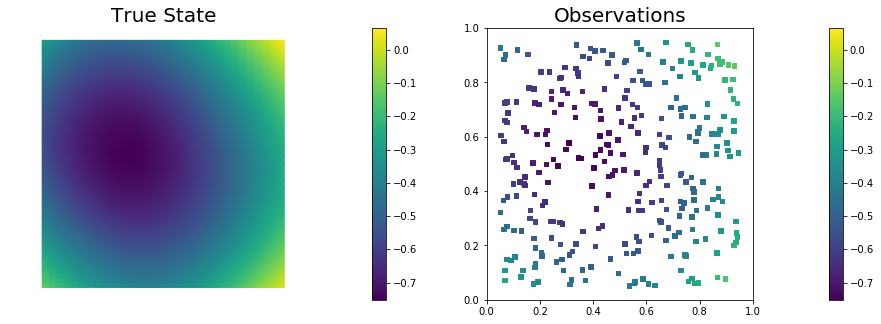

In [15]:
omega = dl.Constant(1.0)
    
def pde_varf(u,m,p):
    return -dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx + omega*omega*dl.exp(2*m)*dl.inner(u, p)*dl.dx - f*p*dl.dx  + g*p*dl.ds
    
pde = hp.PDEVariationalProblem(Vh, pde_varf, [], [], is_fwd_linear=True)

model = hp.Model(pde,prior, misfit)

utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[hp.STATE], x, 1e-9)
misfit.B.mult(x[hp.STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
hp.parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), misfit.d.max() )
vmin = min( utrue.min(), misfit.d.min() )

plt.figure(figsize=(15,5))
hp.nb.plot(dl.Function(Vh[hp.STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
hp.nb.plot_pts(targets, misfit.d, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)
plt.show()

In [18]:
m = x[hp.PARAMETER].copy()    
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    1.979484e+02    1.628790e+02    3.506946e+01   -5.287818e-10   1.810714e+00   1.000000e+00   5.000000e-01
  2   3    1.979484e+02    1.628790e+02    3.506946e+01   -1.737940e-11   1.755222e-01   1.000000e+00   3.113444e-01
  3  20    1.979484e+02    1.628791e+02    3.506939e+01   -9.255080e-09   1.212789e-01   1.000000e+00   2.588020e-01
  4  18    1.979484e+02    1.628791e+02    3.506939e+01   -1.975230e-10   1.686998e-02   1.000000e+00   9.652334e-02
  5  25    1.979484e+02    1.628791e+02    3.506939e+01   -4.324023e-11   5.311880e-03   1.000000e+00   5.416256e-02
  6  26    1.979484e+02    1.628791e+02    3.506939e+01   -7.262502e-12   1.396355e-03   9.765625e-04   2.776982e-02

Not Converged
Termination reason:  Maximum number of backtracking reached
Final gradient norm:  0.0013963551383309885
Final cost:  197.94844157407957


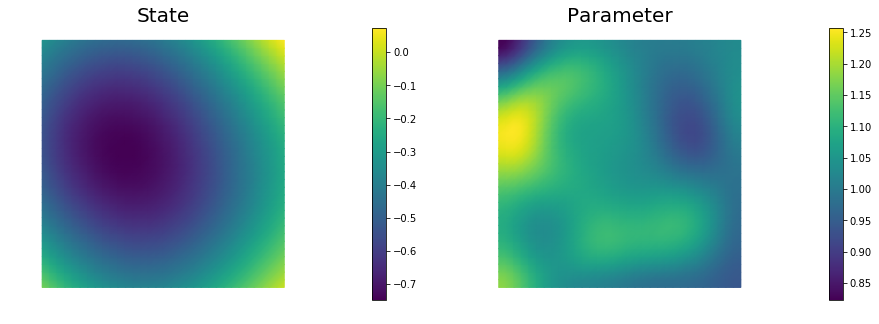

In [19]:
plt.figure(figsize=(15,5))
hp.nb.plot(dl.Function(Vh[hp.STATE], x[hp.STATE]), subplot_loc=121,mytitle="State")
hp.nb.plot(dl.Function(Vh[hp.PARAMETER], x[hp.PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()

In [22]:
hp.parRandom.

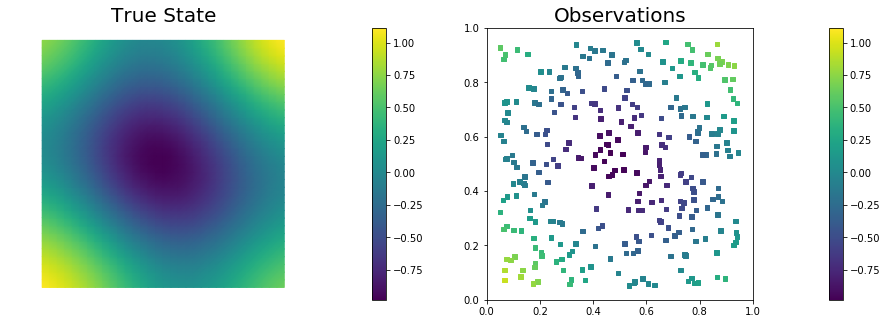

In [23]:
omega = dl.Constant(2)

def pde_varf(u,m,p):
    return -dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx + omega*omega*dl.exp(2*m)*dl.inner(u, p)*dl.dx - f*p*dl.dx  + g*p*dl.ds
    
pde = hp.PDEVariationalProblem(Vh, pde_varf, [], [], is_fwd_linear=True)

model = hp.Model(pde,prior, misfit)


utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[hp.STATE], x, 1e-9)
misfit.B.mult(x[hp.STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
hp.parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), misfit.d.max() )
vmin = min( utrue.min(), misfit.d.min() )

plt.figure(figsize=(15,5))
hp.nb.plot(dl.Function(Vh[hp.STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
hp.nb.plot_pts(targets, misfit.d, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)
plt.show()

In [24]:
m = x[hp.PARAMETER]    
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason])
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    1.210937e+04    1.155209e+04    5.572756e+02   -7.182164e+03   2.562267e+06   1.000000e+00   5.000000e-01
  2   2    1.721970e+03    1.165610e+03    5.563603e+02   -2.069778e+04   2.054975e+06   1.000000e+00   5.000000e-01
  3   2    1.123640e+03    5.672990e+02    5.563413e+02   -1.196509e+03   5.821346e+05   1.000000e+00   4.766499e-01
  4   4    9.876488e+02    4.315521e+02    5.560967e+02   -2.745592e+02   4.789972e+05   1.000000e+00   4.323687e-01
  5   6    9.044689e+02    3.497649e+02    5.547040e+02   -1.660438e+02   4.464227e+05   1.000000e+00   4.174082e-01
  6   9    7.340509e+02    1.908187e+02    5.432322e+02   -3.493439e+02   4.389768e+05   1.000000e+00   4.139125e-01
  7   1    7.255979e+02    1.823664e+02    5.432315e+02   -1.681870e+01   4.423579e+05   1.000000e+00   4.155035e-01
  8   2    7.246485e+02    1.814264e+02    5.432222e+02   -1.

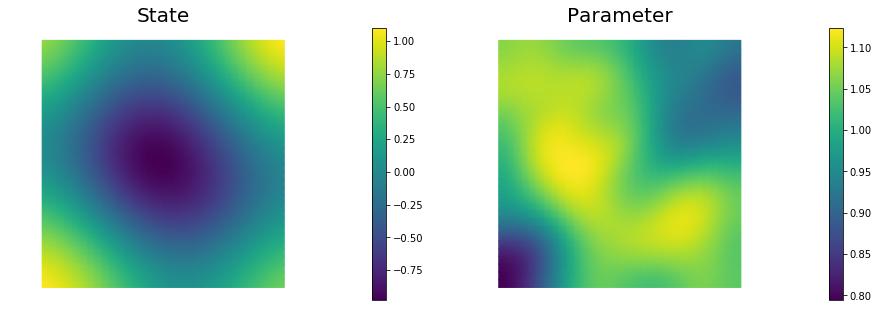

In [26]:
plt.figure(figsize=(15,5))
hp.nb.plot(dl.Function(Vh[hp.STATE], x[hp.STATE]), subplot_loc=121,mytitle="State")
hp.nb.plot(dl.Function(Vh[hp.PARAMETER], x[hp.PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()

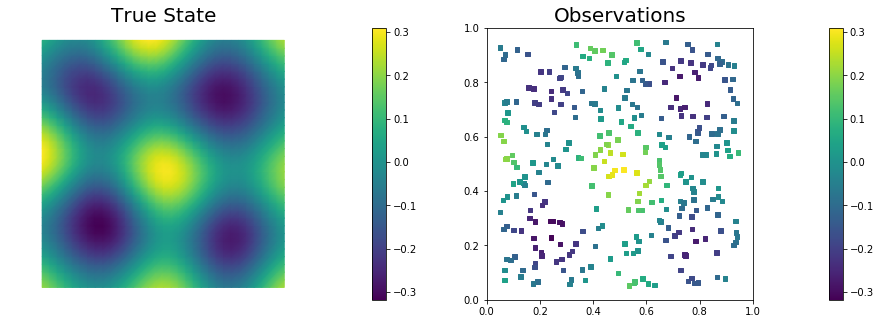

In [30]:
omega = dl.Constant(4)

def pde_varf(u,m,p):
    return -dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx + omega*omega*dl.exp(2*m)*dl.inner(u, p)*dl.dx - f*p*dl.dx  + g*p*dl.ds
    
pde = hp.PDEVariationalProblem(Vh, pde_varf, [], [], is_fwd_linear=True)

model = hp.Model(pde,prior, misfit)


utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[hp.STATE], x, 1e-9)
misfit.B.mult(x[hp.STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
hp.parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), misfit.d.max() )
vmin = min( utrue.min(), misfit.d.min() )

plt.figure(figsize=(15,5))
hp.nb.plot(dl.Function(Vh[hp.STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
hp.nb.plot_pts(targets, misfit.d, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)
plt.show()

In [31]:
m = x[hp.PARAMETER]    
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    2.818511e+04    2.817215e+04    1.296265e+01   -5.227804e+03   2.209015e+07   1.000000e+00   5.000000e-01
  2   3    6.215179e+03    6.202868e+03    1.231125e+01   -4.466087e+04   1.083433e+07   1.000000e+00   5.000000e-01
  3   1    5.437235e+03    5.424925e+03    1.230994e+01   -1.680497e+03   2.658307e+07   1.000000e+00   5.000000e-01
  4   1    5.393474e+03    5.381164e+03    1.231016e+01   -8.899793e+01   1.014284e+07   1.000000e+00   5.000000e-01
  5   3    3.655595e+03    3.643319e+03    1.227594e+01   -3.415476e+03   2.495231e+06   1.000000e+00   3.360904e-01
  6   7    1.923137e+03    1.911114e+03    1.202365e+01   -3.870785e+03   1.189684e+06   1.000000e+00   2.320687e-01
  7   1    1.866376e+03    1.854352e+03    1.202412e+01   -1.073898e+02   5.462132e+06   1.000000e+00   4.972580e-01
  8   7    1.278461e+03    1.266001e+03    1.246006e+01   -1.

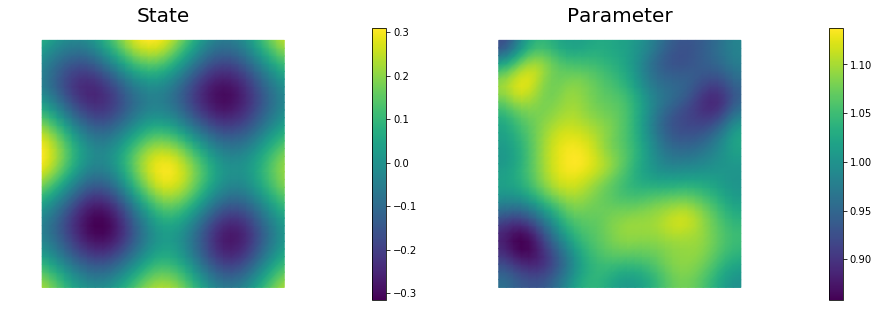

In [32]:
plt.figure(figsize=(15,5))
hp.nb.plot(dl.Function(Vh[hp.STATE], x[hp.STATE]), subplot_loc=121,mytitle="State")
hp.nb.plot(dl.Function(Vh[hp.PARAMETER], x[hp.PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()

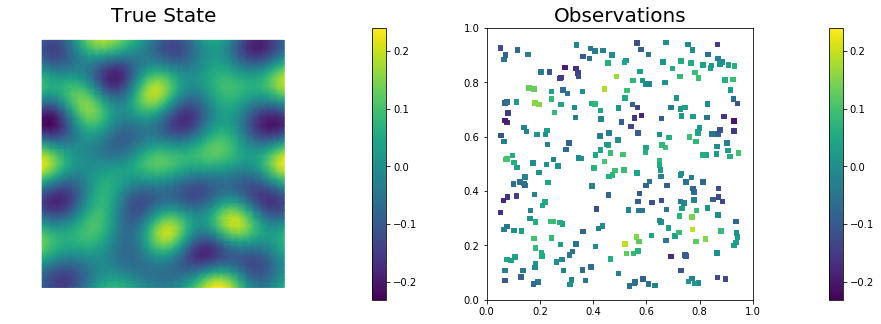

In [34]:
omega = dl.Constant(8)

def pde_varf(u,m,p):
    return -dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx + omega*omega*dl.exp(2*m)*dl.inner(u, p)*dl.dx - f*p*dl.dx  + g*p*dl.ds
    
pde = hp.PDEVariationalProblem(Vh, pde_varf, [], [], is_fwd_linear=True)

model = hp.Model(pde,prior, misfit)


utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[hp.STATE], x, 1e-9)
misfit.B.mult(x[hp.STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
hp.parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), misfit.d.max() )
vmin = min( utrue.min(), misfit.d.min() )

plt.figure(figsize=(15,5))
hp.nb.plot(dl.Function(Vh[hp.STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
hp.nb.plot_pts(targets, misfit.d, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)
plt.show()

In [36]:
m = x[hp.PARAMETER]    
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1  54    1.377338e+02    9.723303e+01    4.050074e+01   -1.620797e-03   2.423096e+02   1.000000e+00   5.000000e-01
  2   1    1.377338e+02    9.723303e+01    4.050074e+01   -5.537411e-09   1.657301e+02   1.000000e+00   5.000000e-01
  3 102    1.377331e+02    9.727907e+01    4.045403e+01   -1.360675e-03   1.562670e+02   1.000000e+00   5.000000e-01
  4   1    1.377331e+02    9.727907e+01    4.045403e+01   -1.712781e-08   1.386543e+02   1.000000e+00   5.000000e-01
  5  19    1.377331e+02    9.727855e+01    4.045453e+01   -3.483962e-05   9.981974e+01   1.000000e+00   5.000000e-01
  6  98    1.377329e+02    9.727014e+01    4.046279e+01   -2.896543e-04   7.297725e+01   1.000000e+00   5.000000e-01
  7   1    1.377329e+02    9.727014e+01    4.046279e+01   -5.341850e-10   5.150555e+01   1.000000e+00   4.610433e-01
  8  42    1.377329e+02    9.727108e+01    4.046184e+01   -3.

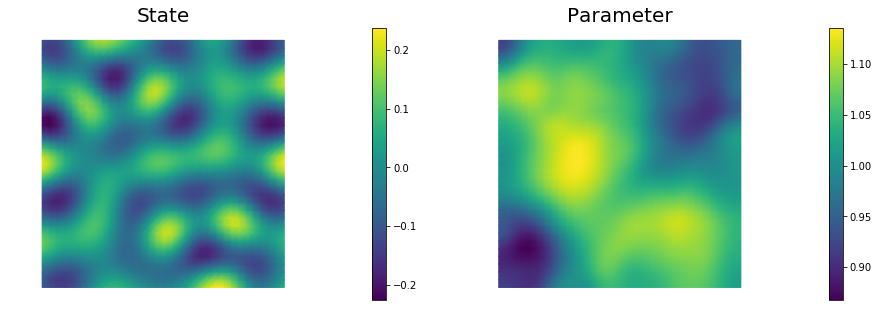

In [37]:
plt.figure(figsize=(15,5))
hp.nb.plot(dl.Function(Vh[hp.STATE], x[hp.STATE]), subplot_loc=121,mytitle="State")
hp.nb.plot(dl.Function(Vh[hp.PARAMETER], x[hp.PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()